# FCN Train and Test

### Import libraries and gpu availability checking

In [2]:
import pandas as pd
import torch
import numpy as np
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch.nn as nn
from fcn import SimplifiedClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,roc_curve
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset, random_split
import os
import sys
from IPython import get_ipython
from pathlib import Path

notebook_path = get_ipython().run_line_magic("pwd", "")
project_root = Path(notebook_path).parent.parent.parent
sys.path.append(str(project_root))
from modules.modules_kidera.gpu import GPU
use_gpu=True
device=GPU(use_gpu)


### Data preparation

In [3]:
def load_data():
    """Load and return all required datasets"""
    encoded_cdr3 = np.load(f'{DATA_DIR}/autoencoder_vdjdb_train/encoded_cdr3.npy')
    encoded_epitope = np.load(f'{DATA_DIR}/autoencoder_epitope_train/encoded_epitope.npy')
    
    binding = pd.read_csv(f'{DATA_DIR}/autoencoder_vdjdb_train/binding.csv')

    X_train_fcn = pd.read_csv(f'{DATA_DIR}/autoencoder_fcn/X_train.csv')
    
    return encoded_cdr3, encoded_epitope, binding, X_train_fcn

def prepare_tensors(encoded_cdr3, encoded_epitope, binding, train_size):
    """Combine features and prepare PyTorch tensors"""
    encoded_all = np.hstack((encoded_cdr3, encoded_epitope))

    X = torch.tensor(encoded_all, dtype=torch.float32).to(device)
    y = torch.tensor(binding['bind'].values, dtype=torch.float32).view(-1, 1).to(device)
    
    return X, y

def split_data(X, y, train_size):
    """Split data into training and test sets"""
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    
    return X_train, X_test, y_train, y_test
encoded_cdr3, encoded_epitope, binding, X_train_fcn = load_data()
  
X, y = prepare_tensors(encoded_cdr3, encoded_epitope, binding, X_train_fcn.shape[0])
X_train, X_test, y_train, y_test = split_data(X, y, X_train_fcn.shape[0])

### Training 

/home/mbelyakov/.conda/envs/env1/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Эпоха [1/30], Train Loss: 0.6958, Val Loss: 0.6821, ROC AUC: 0.5362
Эпоха [2/30], Train Loss: 0.6868, Val Loss: 0.6787, ROC AUC: 0.5292
Эпоха [3/30], Train Loss: 0.6832, Val Loss: 0.6750, ROC AUC: 0.5524
Эпоха [4/30], Train Loss: 0.6800, Val Loss: 0.6725, ROC AUC: 0.5576
Эпоха [5/30], Train Loss: 0.6773, Val Loss: 0.6706, ROC AUC: 0.5630
Эпоха [6/30], Train Loss: 0.6753, Val Loss: 0.6676, ROC AUC: 0.5709
Эпоха [7/30], Train Loss: 0.6739, Val Loss: 0.6675, ROC AUC: 0.5730
Эпоха [8/30], Train Loss: 0.6718, Val Loss: 0.6669, ROC AUC: 0.5707
Эпоха [9/30], Train Loss: 0.6709, Val Loss: 0.6661, ROC AUC: 0.5789
Эпоха [10/30], Train Loss: 0.6693, Val Loss: 0.6641, ROC AUC: 0.5790
Эпоха [11/30], Train Loss: 0.6678, Val Loss: 0.6641, ROC AUC: 0.5836
Эпоха [12/30], Train Loss: 0.6664, Val Loss: 0.6627, ROC AUC: 0.5881
Эпоха [13/30], Train Loss: 0.6669, Val Loss: 0.6622, ROC AUC: 0.5952
Эпоха [14/30], Train Loss: 0.6642, Val Loss: 0.6583, ROC AUC: 0.5963
Эпоха [15/30], Train Loss: 0.6623, Val Loss

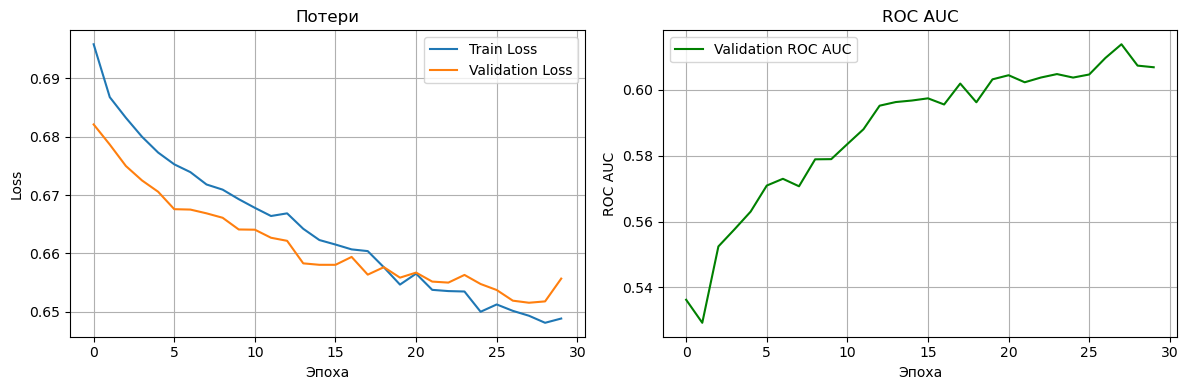

In [38]:

# Scaling
scaler = StandardScaler()
X_train_np = X_train.cpu().numpy()
X_train_scaled = scaler.fit_transform(X_train_np)
X_train = torch.tensor(X_train_scaled, dtype=torch.float32)

y_train = y_train.float()

# Division on train and test
full_dataset = TensorDataset(X_train, y_train)
train_size = int(0.9 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

# Model and optimization
model = SimplifiedClassifier(input_dim=128).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5, verbose=True)

# Early stopping параметры
best_auc = 0.0
early_stop_counter = 0
patience = 7
best_model_state = None

train_loss_history = []
val_loss_history = []
roc_auc_history = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * batch_X.size(0)

    train_loss /= len(train_loader.dataset)
    train_loss_history.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for val_X, val_y in val_loader:
            val_X, val_y = val_X.to(device), val_y.to(device)
            outputs = model(val_X)
            loss = criterion(outputs, val_y)
            val_loss += loss.item() * val_X.size(0)

            probs = torch.sigmoid(outputs)
            all_preds.extend(probs.cpu().numpy())
            all_targets.extend(val_y.cpu().numpy())

    val_loss /= len(val_loader.dataset)
    val_loss_history.append(val_loss)

    try:
        val_auc = roc_auc_score(all_targets, all_preds)
    except ValueError:
        val_auc = 0.0

    roc_auc_history.append(val_auc)
    scheduler.step(val_loss)

    print(f"Эпоха [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, ROC AUC: {val_auc:.4f}")

    # Early stopping
    if val_auc > best_auc:
        best_auc = val_auc
        early_stop_counter = 0
        best_model_state = model.state_dict()
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print(f"Early stopping на эпохе {epoch+1}. Лучшая ROC AUC: {best_auc:.4f}")
            if best_model_state is not None:
                model.load_state_dict(best_model_state)
            break

# Graphs
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Эпоха')
plt.ylabel('Loss')
plt.title('Потери')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(roc_auc_history, label='Validation ROC AUC', color='green')
plt.xlabel('Эпоха')
plt.ylabel('ROC AUC')
plt.title('ROC AUC')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


### Testing


📊 Результаты на тесте:
Accuracy:  0.5149
Precision: 0.7675
Recall:    0.1760
F1 Score:  0.2864
ROC AUC:   0.6145


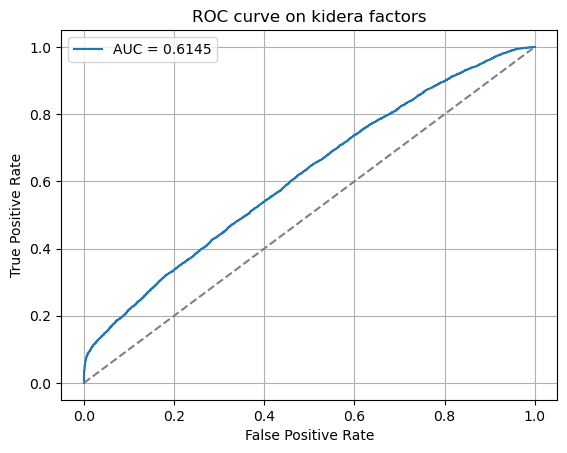

In [41]:
# тестим

model.eval()
X_test_np = X_test.cpu().numpy()  
X_test_scaled = scaler.transform(X_test_np)
X_test = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
with torch.no_grad():
    y_pred_probs = model(X_test).cpu().numpy()
    y_true = y_test.cpu().numpy()

y_true = y_true.reshape(-1)
y_pred_probs = y_pred_probs.reshape(-1)
y_pred = (y_pred_probs >= 0.5).astype(int)
# Метрики
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_pred_probs)

print(f"\n📊 Результаты на тесте:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"ROC AUC:   {roc_auc:.4f}")

# === ROC-кривая ===
fpr, tpr, _ = roc_curve(y_true, y_pred_probs)
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve on kidera factors')
plt.legend()
plt.grid(True)
plt.show()
